In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

In [4]:
! pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
path = "data"
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [17]:
data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "test"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = 4,
                                                shuffle = True)
                     for x in ["train", "test"]}

In [7]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [20]:
classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}


In [21]:
data_image

{'train': Dataset ImageFolder
     Number of datapoints: 20000
     Root location: data\train
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ), 'test': Dataset ImageFolder
     Number of datapoints: 5000
     Root location: data\test
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            )}

In [10]:
print("train data set:", len(data_image["train"]))
print("val data set:", len(data_image["test"]))

train data set: 20000
val data set: 5000


['cats', 'dogs', 'cats', 'dogs']


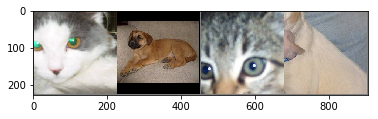

In [11]:
X_train,y_train = next(iter(data_loader_image["train"]))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std + mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [12]:
model = models.vgg16(pretrained = True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\karki/.cache\torch\hub\checkpoints\vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [13]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        parma.requires_grad = True
    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
n_epochs = 1
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch{}/{}".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "test"]:
        if param == "train":
            model.train = True
        else:
            model.train = False
            
        running_loss = 0.0
        running_correct = 0
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X,y = data
            if use_gpu:
                X,y - Variable(X.cuda()), Variable(y.cuda())
            else:
                X,y = Variable(X), Variable(y)
            
            optimizer.zero_grad()
            y_pred = model(X)
            _,pred = torch.max(y_pred.data, 1)
            
            loss = cost(y_pred,y)
            if param == "train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data
            running_correct += torch.sum(pred == y.data)
            if batch%5 == 0 and param == "train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
                
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])
        
        print("{} Loss:{:.4f}, Correct:{:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch0/1
----------
Batch 5, Train Loss:0.7234, Train ACC:80.0000
Batch 10, Train Loss:1.1394, Train ACC:75.0000
Batch 15, Train Loss:1.1917, Train ACC:76.6667
Batch 20, Train Loss:1.2160, Train ACC:80.0000
Batch 25, Train Loss:1.5730, Train ACC:81.0000
Batch 30, Train Loss:2.2035, Train ACC:78.3333
Batch 35, Train Loss:2.0308, Train ACC:78.5714
Batch 40, Train Loss:2.2817, Train ACC:78.7500
Batch 45, Train Loss:2.8662, Train ACC:77.7778
Batch 50, Train Loss:3.2966, Train ACC:77.5000
Batch 55, Train Loss:3.2858, Train ACC:78.1818
Batch 60, Train Loss:3.2978, Train ACC:77.5000
Batch 65, Train Loss:3.0441, Train ACC:79.2308
Batch 70, Train Loss:3.3792, Train ACC:78.9286
Batch 75, Train Loss:3.3692, Train ACC:78.6667
Batch 80, Train Loss:3.2438, Train ACC:79.6875
Batch 85, Train Loss:3.0954, Train ACC:80.2941
Batch 90, Train Loss:3.1155, Train ACC:80.0000
Batch 95, Train Loss:2.9736, Train ACC:80.7895
Batch 100, Train Loss:2.8576, Train ACC:81.5000
Batch 105, Train Loss:2.8553, Train ACC:

KeyboardInterrupt: 

In [72]:
data_test_img = datasets.ImageFolder(root="dog_vs_cat/test/", transform = transform)
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                  batch_size = 16)

In [73]:
image, label = next(iter(data_loader_test_img))
images = Variable(image)
y_pred = model(images)
_,pred = torch.max(y_pred.data, 1)
print(pred)


 0
 0
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 1
 1
 0
 0
[torch.LongTensor of size 16]



('Pred Label:', ['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat'])


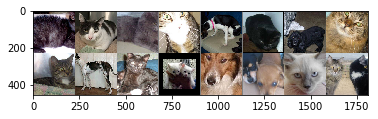

In [74]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = img * std + mean
print("Pred Label:", [classes[i] for i in pred])
plt.imshow(img)